In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime as dt
from copy import deepcopy
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.optimize import fsolve
import backtest_library as bl

In [2]:
start_date = pd.to_datetime('2022-09-01')
end_date = pd.to_datetime('2022-09-30')
stocks_list = ['SPY','TSLA','UVXY','AAPL','NVDA','QQQ','SLV']
stocks_list = ['SPY','TSLA','AAPL','NVDA','QQQ','SLV']
stocks_list = ['SPY','TSLA']
market = bl.Market(stocks_list,start_date,end_date)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed


/Users/renevey/Library/Mobile Documents/com~apple~CloudDocs/Quant/Python/Quant personal projects/backtesting/backtest_library.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data=data.loc[data.groupby(data.QUOTE_DATE).idxmin().STRIKE_DISTANCE]
/Users/renevey/Library/Mobile Documents/com~apple~CloudDocs/Quant/Python/Quant personal projects/backtesting/backtest_library.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data=data.loc[data.groupby(data.QUOTE_DATE).idxmin().STRIKE_DISTANCE]


In [3]:
market.options['SPY']

,strike,DTE,callPrice,callIV,putPrice,putIV,C_BID,C_ASK
date,,,,,,,,
2022-09-01,396.0,1.0,2.69,0.297093,2.31,0.305707,2.69,2.7
2022-09-02,392.0,4.0,2.41,0.135877,2.72,0.176932,2.4,2.42
2022-09-06,391.0,1.0,1.96,0.252770,2.35,0.274901,1.98,2.0
2022-09-07,398.0,2.0,2.74,0.239793,3.03,0.251198,2.79,2.81
2022-09-08,400.0,1.0,2.05,0.219773,1.67,0.223658,2.04,2.06
2022-09-09,407.0,3.0,1.72,0.126876,2.06,0.129552,1.71,1.73
2022-09-12,411.0,2.0,3.67,0.300872,3.84,0.317966,3.68,3.69
2022-09-13,393.0,1.0,2.76,0.328071,2.42,0.302959,2.72,2.74
2022-09-14,395.0,2.0,2.69,0.244737,4.16,0.342409,2.69,2.7


In [83]:
time = start_date
end = end_date   

pos_ini_benchmark=bl.Position(market,time,stock_pos=[0,1]+[0]*(len(market.tickers)-1))
bm=bl.Portfolio(pos_ini_benchmark,end)

def strat(pos,param):
    ticks=pos.market.tickers
    time = pos.time
    stocks = pos.market.stocks
    options = pos.market.options
    money = pos.stock_pos[0]
    if money == 0:
        return pos
    
    ranking = {name: stocks[name].histVol[time]-options[name].callIV[time] for name in ticks}
    ranking = {x:y for x,y in ranking.items() if y>0}
    new_alloc = {x:y/sum([y for x,y in ranking.items()])*money/options[x].callPrice[time] for x,y in ranking.items()}
    new_alloc_call = {ticks.index(x):new_alloc[x] for x in new_alloc if ticks.index(x)%2 == 0}
    
    new_call_pos = deepcopy(pos.call_pos)
    for x,y in new_alloc_call.items():
        new_call_pos[x].append([options[ticks[x]].strike[time],options[ticks[x]].DTE[time],y])
        
    new_put_pos = deepcopy(pos.put_pos)
        
    return bl.Position(pos.market,time,[0]+[0]*len(market.tickers),new_call_pos,new_put_pos)

pos=bl.Position(market,time,[1000]+[0]*len(market.tickers),[[]]*len(market.tickers),[[]]*len(market.tickers))
my_strat=bl.Portfolio(pos,end,strat)

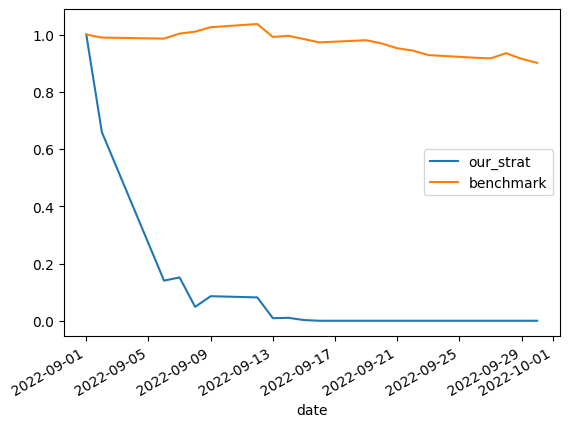

In [84]:
my_strat.compare(bm)